In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# initialize afinn sentiment analyzer
!pip install afinn

from afinn import Afinn
af = Afinn()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 820 kB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=f4223807e0decc8edfab847334b8f0d781e14efbd63386e93fbd0acc6bfec152
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 2.1 MB/s 
     |████████████████████████████████| 209 kB 49.4 MB/s 
     |████████████████████████████████| 81 kB 9.1 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 147 kB 70.0 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 112 kB 48.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os,string#,path

#wordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from urllib.request import urlopen
from PIL import Image

#Text Processing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%matplotlib inline

#ML Model
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgbm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

#Optimisation
import pickle
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) #Disable Warnings
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

>Functions

In [ ]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

def countplot(df, x, x_axis_title,y_axys_title, plot_title):
    plt.figure(figsize=(20,8))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.countplot(data = df,x=x,order = df[x].value_counts().index,palette="Blues_d")
    for p in ax.patches:
        ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(0, 3),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    plt.xticks(rotation=0,fontsize = 12)
    ax.set_xlabel(x_axis_title,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False)  
    plt.title(plot_title, fontsize = 16,weight = 'bold')  

def preprocess_sentence(df): #returns the whole sentence, with preprocessed text
    word_list = []
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', df) #remove punctuations
    #text = text.lower() #lower case
    tokenized_word=word_tokenize(text) #separate into words
    for word in tokenized_word:
        if word not in stop_words: #filter stop-words
            word = stem.stem(word) #stemming
            word_list.append(word) #append to general list
    return ' '.join(word_list) #rejoins the sentence without the stopwords

def process_list(text): #returns a list of preprocessed words
        word_list = []
        #for t in text:            
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text) #remove punctuations
        text = text.lower() #lower case
        tokenized_word=word_tokenize(text) #separate into words
        for word in tokenized_word:
            if word not in stop_words: #filter stop-words
                word = stem.stem(word) #stemming
                word_list.append(word) #append to general list
        return word_list
    
def build_freqs(texts, author):
    authorslist = np.squeeze(author).tolist()
    # Start with an empty dictionary and populate it by looping over all samples
    # and over all processed words in each sample.
    freqs = {}
    words_sample = []
    for text, author in zip(texts,authorslist):
        for word in process_list(text):
            words_sample.append(word)
            pair = (word, author)
            freqs[pair] = freqs.get(pair, 0) + 1  
    return freqs,words_sample

stop_words=set(stopwords.words("english"))
stem = PorterStemmer()

# 1. Data Analysis

In this section we will perform an overall analysis of the data. First, we analyse if there are any duplicates, missing entries or any need for data cleansing. Next, we start to create new features to understand the trends between the authors, such as: word count per sample, number of characters and so on. In the following section, we use the Affin Sentiment analysis library to see if there is any interesting pattern between the authors, perhaps one author has a more negative style of writing than the others. The Word Frequency of the individual authors and for the whole corpus is also performed. Finally, a Word Co-Occurrence analysis is presented. 

The analysis start below, by importing the training and test sets. A sample of the data is shown below:

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/assignment1 autho classifcaition/train-authors - train-authors.csv')
df_test = pd.read_csv('/content/drive/MyDrive/assignment1 autho classifcaition/test-authors - test-authors.csv')
pd.set_option('display.max_colwidth', None)
df_train.head()

,text,author
0,"She wanted clothes to keep her warm, and food to\neat; but she had kept it safe, and had it in her bosom. It was gold, I\ntell you! Rich gold, that might have saved her life!”\n\n“Gold!” echoed the matron, bending eagerly over the woman as she fell\nback",dickens
1,"The question now was, who was the man,\nand who was it brought him the coronet?\n\n“It is an old maxim of mine that when you have excluded the impossible,\nwhatever remains, however improbable, must be the truth",doyle
2,"I therefore\n smoked a great number of those excellent cigarettes, and I\n dropped the ash all over the space in front of the suspected\n bookcase. We then ascended to\n the room again, when, by upsetting the cigarette-box, I obtained\n a very excellent view of the floor, and was able to see quite\n clearly, from the traces upon the cigarette ash, that the\n prisoner had in our absence come out from her retreat",doyle
3,"I am partial to the modern\nFrench school. \nWilliams, who drove you to-night, was one of them. \n\n“When we entered his room he was propped up with pillows and breathing\nheavily. He thought, too, that if we parted with the chaplet\nit might give rise to gossip and finally bring us into trouble",doyle
4,"” She stood smiling, holding up a little slip of paper in\nthe air. \n\n“May I see it?”\n\n“Certainly. ”\n\nHe snatched it from her in his eagerness, and smoothing it out upon\nthe table, he drew over the lamp, and examined it intently",doyle


From a basic EDA we conclude that there is basic need for data cleansing, as there are no missing entries or duplicated values. The bar plot below shows the number of samples per author:

In [ ]:
df_train.sample(5)

,text,author
997,"’\n\nThe astonishment of the village may be easily imagined, when (the little\nstone having been raised with one wrench of a spade) Mr. Pickwick, by\ndint of great personal exertion, bore it with his own hands to the inn,\nand after having carefully washed it, deposited it on the table",dickens
15212,"There, sir. You are free to go, and we to follow. \nBut I warn you, by all I hold most solemn and most sacred, that instant\nwill have you apprehended on a charge of fraud and robbery. I am\nresolute and immoveable",dickens
18141,"I reckon\nyou ain't used to lying, it don't seem to come handy; what you want is\npractice. You do it pretty awkward. ”\n\nI didn't care nothing for the compliment, but I was glad to be let off,\nanyway. \n\nThe doctor he started to say something, and turns and says:\n\n“If you'd been in town at first, Levi Bell--” The king broke in and\nreached out his hand, and says:\n\n“Why, is this my poor dead brother's old friend that he's wrote so often\nabout?”\n\nThe lawyer and him shook hands, and the lawyer smiled and looked\npleased, and they talked right along awhile, and then got to one side\nand talked low; and at last the lawyer speaks up and says:\n\n“That 'll fix it",twain
23612,"The people woke up\nmore and more, and sung louder and louder; and towards the end some\nbegun to groan, and some begun to shout. Then the preacher begun to\npreach, and begun in earnest, too; and went weaving first to one side of\nthe platform and then the other, and then a-leaning down over the front\nof it, with his arms and his body going all the time, and shouting his\nwords out with all his might; and every now and then he would hold up\nhis Bible and spread it open, and kind of pass it around this way and\nthat, shouting, “It's the brazen serpent in the wilderness! Look upon\nit and live!” And people would shout out, “Glory!--A-a-_men_!” And so\nhe went on, and the people groaning and crying and saying amen:\n\n“Oh, come to the mourners' bench! come, black with sin! (_Amen_!) come,\nsick and sore! (_Amen_!) come, lame and halt and blind! (_Amen_!) come,\npore and needy, sunk in shame! (_A-A-Men_!) come, all that's worn and\nsoiled and suffering!--come with a broken spirit! come with a contrite\nheart! come in your rags and sin and dirt! the waters that cleanse\nis free, the door of heaven stands open--oh, enter in and be at rest!”\n (_A-A-Men_! _Glory, Glory Hallelujah!_)\n\nAnd so on",twain
16053,"No--not always so straightforward as that. Sometimes the\nimpression intentionally conveyed is that it is beautiful, at the same\ntime that the author is careful not to say that it is, in plain Saxon",twain


Number of Samples: 30000,
Number of Features: 2,
Duplicated Entries: 46,
Null Entries: 0,
Number of Rows with Null Entries: 0 0.0%


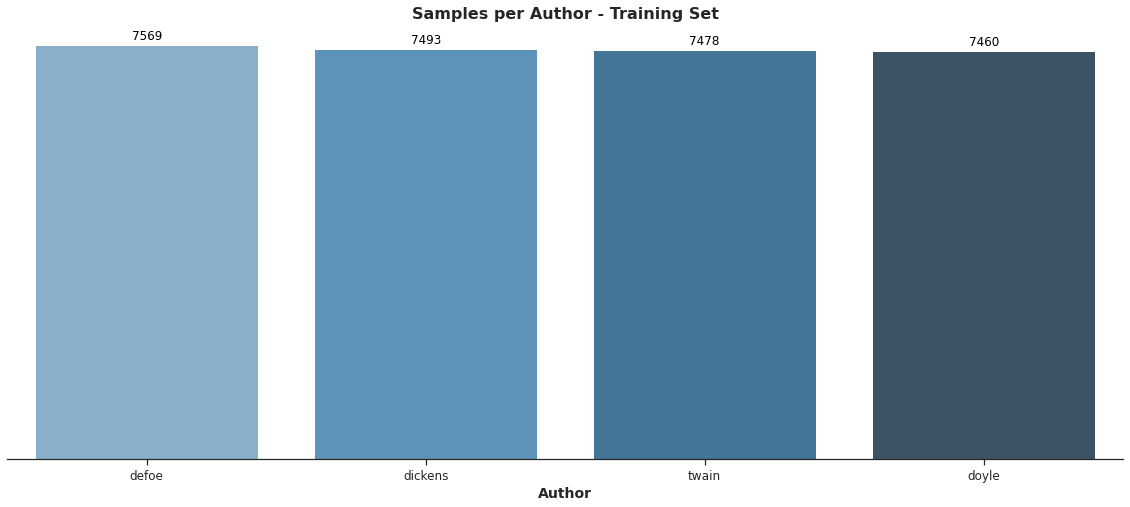

In [ ]:
basic_EDA(df_train)
#df_train['full_name'] = df_train['author'].map(author_dict.get) 
countplot(df_train, 'author', 'Author','Count', 'Samples per Author - Training Set')



*   Train dataset contains 46 duplicated entries, so we have to remove that
* Defoe contains more samples if compared to the other three authors. However, the difference is not as critical as it would require any strategy for data unbalance for now


In [ ]:
df_train  = df_train.drop_duplicates()
basic_EDA(df_train)

Number of Samples: 29954,
Number of Features: 2,
Duplicated Entries: 0,
Null Entries: 0,
Number of Rows with Null Entries: 0 0.0%


## 1.1 Analitycal Text Analysis

In the analytical analysis, we create the following features: 

* Word Count - Total number of words in the sample
* Character Count - Total number of characters in the sample excluding spaces
* Word Density - Average length of the words used in the sample
* Punctuation Count - Total number of punctuations used in the sample
* Upper-Case to Lower-Case Words ratio - ratio of upper case words used and lower case words used in the text

In [ ]:
punctuations = string.punctuation

def new_feat(df):
    df['word_count'] = df['text'].apply(lambda x : len(x.split()))
    df['char_count'] = df['text'].apply(lambda x : len(x.replace(" ","")))
    df['word_density'] = df['word_count'] / (df['char_count'] + 1)

    #Adding +1 to allow ratio calculation
    df['Uppercase'] = df['text'].str.findall(r'[A-Z]').str.len()+1
    df['Lowercase'] = df['text'].str.findall(r'[a-z]').str.len()+1
    df['UppLowRatio'] = df['Uppercase'] / (df['Lowercase'] + 1)

    df['punc_count'] = df['text'].apply(lambda x : len([a for a in x if a in punctuations]))
    
    return df

df_train_new = new_feat(df_train)
#df_test_new = new_feat(df_test)

A KDE plot can help us understand the pattern of the individual authors regarding the new features we created:

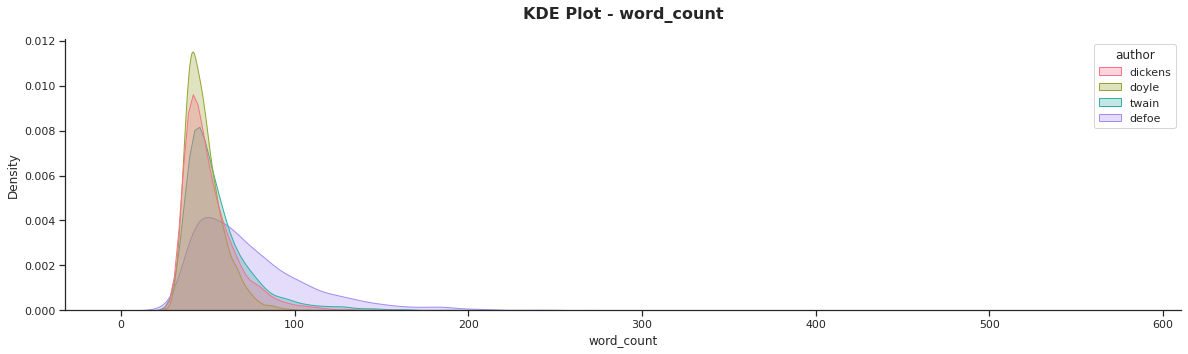

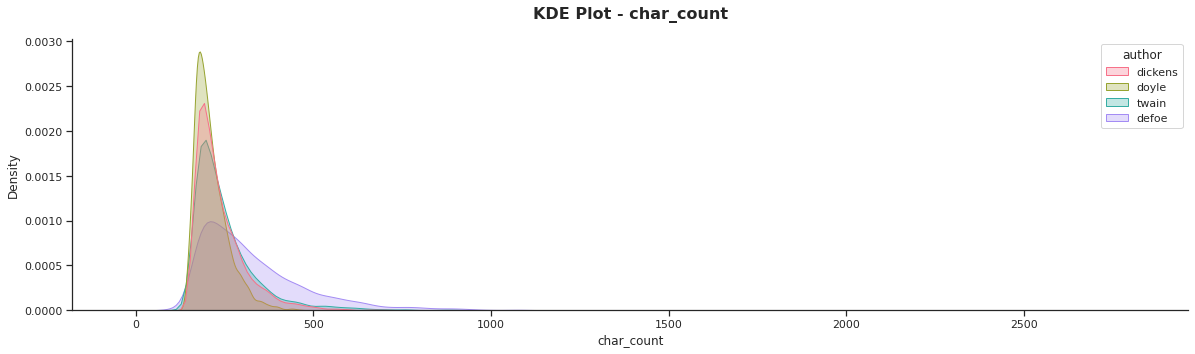

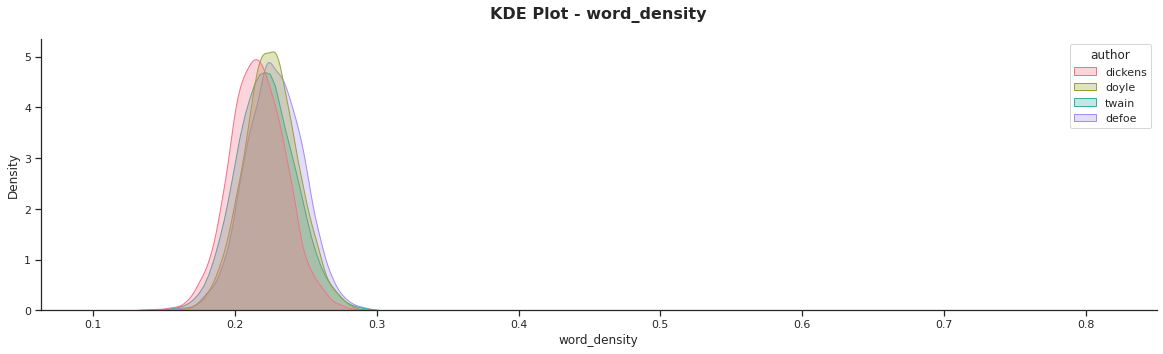

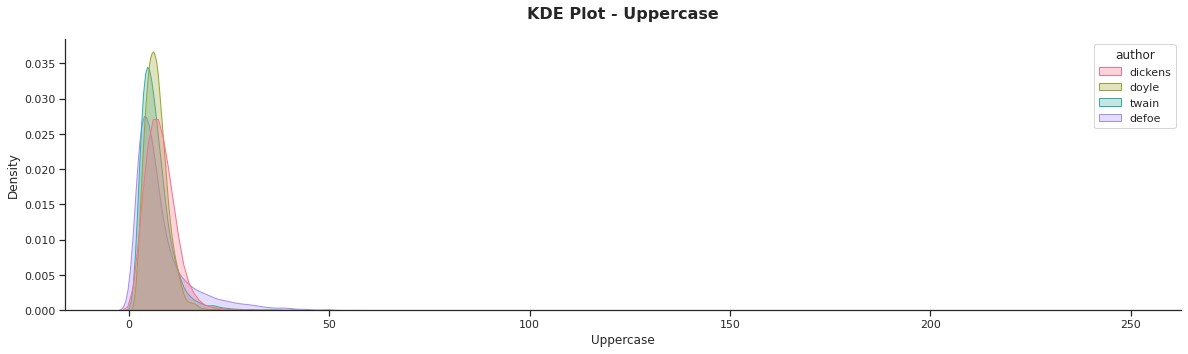

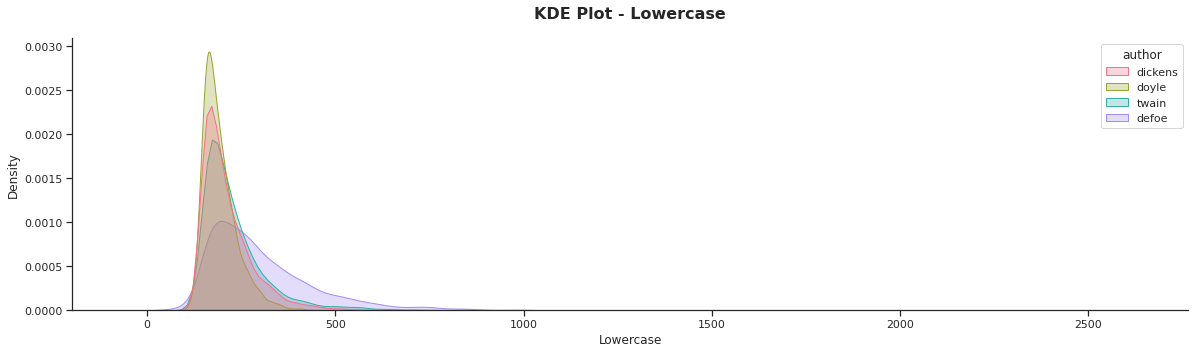

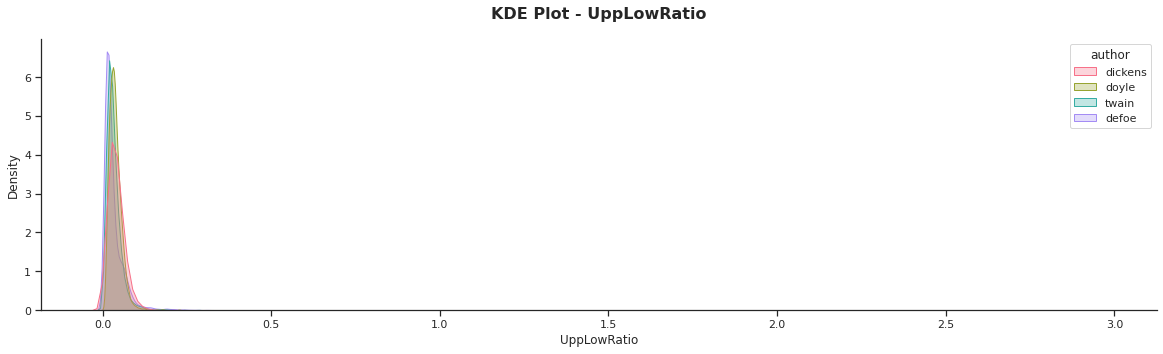

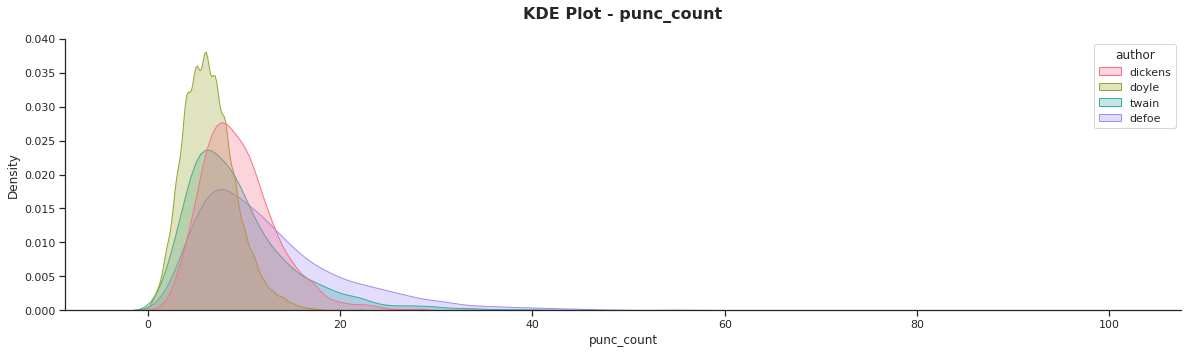

In [ ]:
feat_list = ['word_count','char_count','word_density','Uppercase','Lowercase','UppLowRatio','punc_count']

for i in feat_list:
    plt.figure(figsize=(20,5))
    ax = sns.kdeplot(data = df_train_new, x = i, linewidth=1,alpha=.3, fill = True, hue = 'author',palette = 'husl') 
    ax.set_xlabel(i)
    plt.title('KDE Plot - ' + i, fontsize = 16,weight = 'bold',pad=20);  
    sns.despine(top=True, right=True, left=False, bottom=False)

* In a general manner, all authors have a similar distribution pattern 
*   Defor has less skewed ( high standard deviation) distribution of word count and character count aswell, this can potentially means that Author Defoe has the higher tendency of writing long paragraphs.
* All, but the word_density plot, presents a positive skewed distribution, meaning outliers will present higher values than the mean


## 1.2 Sentiment Analysis

In this section we perform a sentiment analysis using AFFIN lexicon. See https://github.com/darenr/afinn for more info. AFINN is a list of words rated for *valence* with an integer between minus five (negative) and plus five (positive). Here, we are using AFINN-en-165. Basically, for every word of the samples, a value is assigned. After evaluating all the words of a sample, the final result has a positive or negative score, indicating the author intent. 

Clearly, this is a simplistic approach to evaluate the authors ideas. However, it can give us insights and it is also fun to see the algorithm results. 

Look at the result of some samples below, it does seem correct:

In [ ]:
# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(text) for text in df_train['text']]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
sentiment_df = pd.DataFrame([list(df_train['text']), list(df_train['author']),sentiment_scores, sentiment_category]).T
sentiment_df.columns = ['text', 'author','score', 'sentiment_category']
sentiment_df['score'] = sentiment_df.score.astype('float')
sentiment_df.head()

,text,author,score,sentiment_category
0,"She wanted clothes to keep her warm, and food to\neat; but she had kept it safe, and had it in her bosom. It was gold, I\ntell you! Rich gold, that might have saved her life!”\n\n“Gold!” echoed the matron, bending eagerly over the woman as she fell\nback",dickens,12.0,positive
1,"The question now was, who was the man,\nand who was it brought him the coronet?\n\n“It is an old maxim of mine that when you have excluded the impossible,\nwhatever remains, however improbable, must be the truth",doyle,-2.0,negative
2,"I therefore\n smoked a great number of those excellent cigarettes, and I\n dropped the ash all over the space in front of the suspected\n bookcase. We then ascended to\n the room again, when, by upsetting the cigarette-box, I obtained\n a very excellent view of the floor, and was able to see quite\n clearly, from the traces upon the cigarette ash, that the\n prisoner had in our absence come out from her retreat",doyle,3.0,positive
3,"I am partial to the modern\nFrench school. \nWilliams, who drove you to-night, was one of them. \n\n“When we entered his room he was propped up with pillows and breathing\nheavily. He thought, too, that if we parted with the chaplet\nit might give rise to gossip and finally bring us into trouble",doyle,-1.0,negative
4,"” She stood smiling, holding up a little slip of paper in\nthe air. \n\n“May I see it?”\n\n“Certainly. ”\n\nHe snatched it from her in his eagerness, and smoothing it out upon\nthe table, he drew over the lamp, and examined it intently",doyle,1.0,positive


Below is the sample with the most positive sentiment score. The score is computed by word, so longer samples will have higher scores. Something to keep in mind, and perhaps use some kind of normalisation for a more accurate result, but for this analysis it does no harm.

In [ ]:
sentiment_df.loc[sentiment_df['score'].idxmax()]

text                    He said:\n\n“Ah, genteelmen, you come wis me!  I show you beautiful, O, magnificent\nbust Christopher Colombo!--splendid, grand, magnificent!”\n\nHe brought us before the beautiful bust--for it was beautiful--and sprang\nback and struck an attitude:\n\n“Ah, look, genteelmen!--beautiful, grand,--bust Christopher Colombo!\n--beautiful bust, beautiful pedestal!”\n\nThe doctor put up his eye-glass--procured for such occasions:\n\n“Ah--what did you say this gentleman's name was?”\n\n“Christopher Colombo!--ze great Christopher Colombo!”\n\n“Christopher Colombo--the great Christopher Colombo
author                                                                                                                                                                                                                                                                                                                                                                                          

Now the more negative sample found:

In [ ]:
sentiment_df.loc[sentiment_df['score'].idxmin()]

text                  \n\nThe making false lights, sky-lights, trunks, and other contrivances, to\nmake goods look to be what they are not, and to deceive the eye of the\nbuyer, these are all so many brass shillings washed over, in order to\ndeceive the person who is to take them, and cheat him of his money; and\nso far these false lights are really criminal, they are cheats in trade,\nand made to deceive the world; to make deformity look like beauty, and\nto varnish over deficiencies; to make goods which are ordinary in\nthemselves appear fine; to make things which are ill made look well; in\na word, they are cheats in themselves, but being legitimated by custom,\nare become a general practice; the honestest tradesmen have them, and\nmake use of them; the buyer knows of it, and suffers himself to be so\nimposed upon; and, in a word, if it be a cheat, as no doubt it is, they\ntell us that yet it is a universal cheat, and nobody trades without it;\nso custom and usage make it lawful, an

Next, let's count the number of positive, negative and neutral samples each author has:

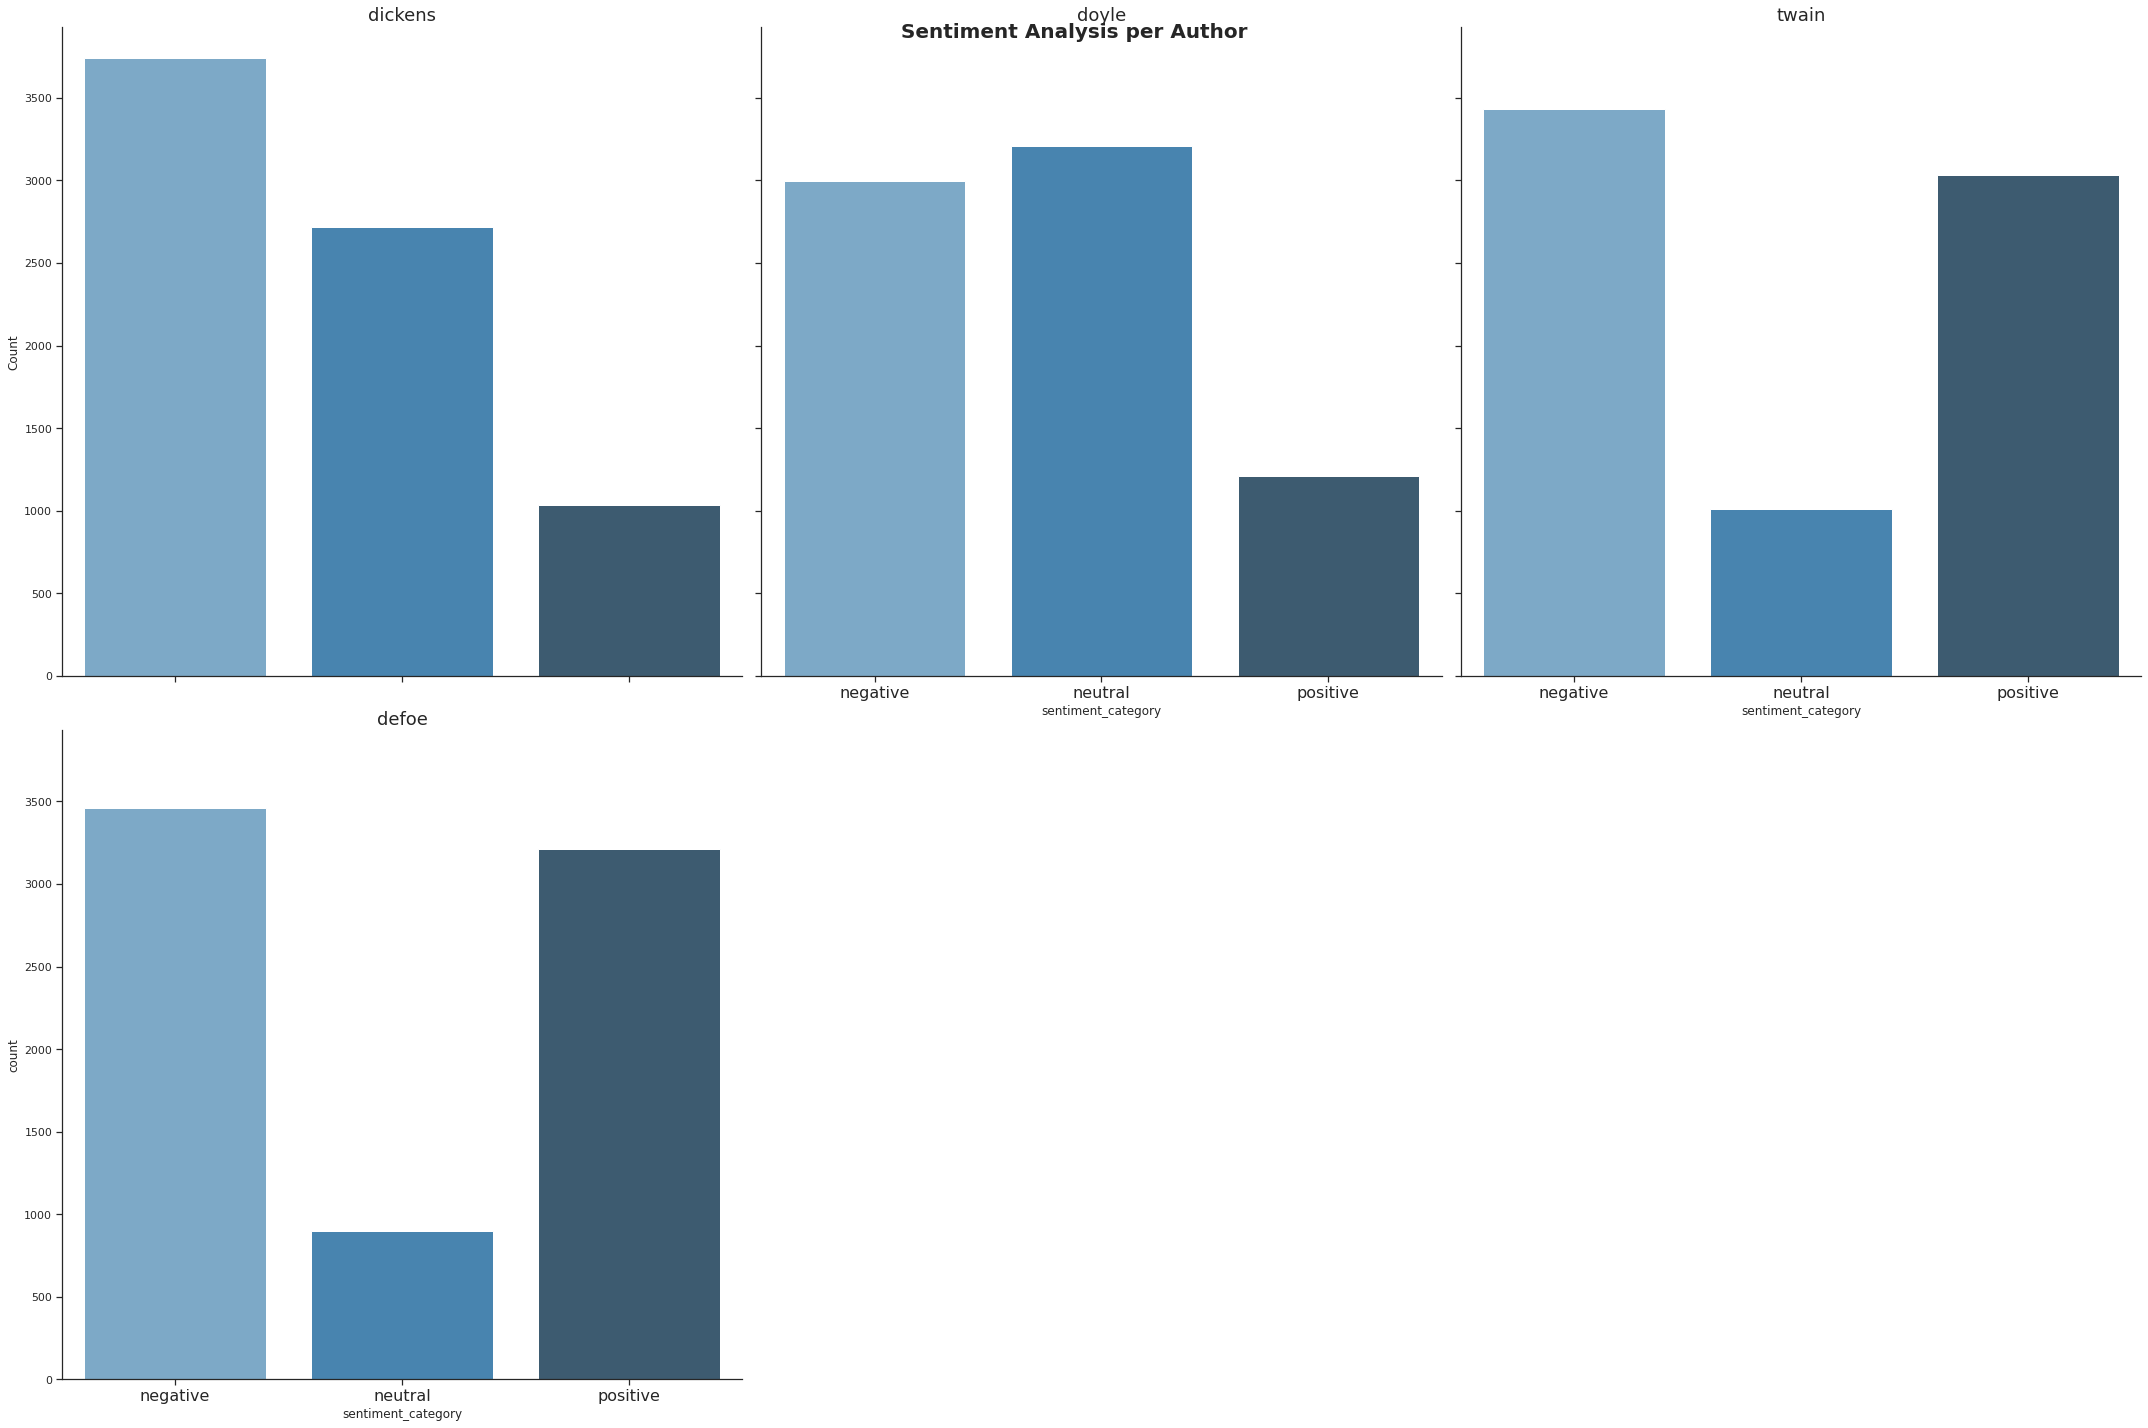

In [ ]:
g = sns.FacetGrid(sentiment_df, col='author', height=10,col_wrap = 3)

g.map_dataframe(sns.countplot,data=sentiment_df, x='sentiment_category',palette="Blues_d")

g.set_titles(col_template="{col_name}", row_template="{row_name}", size = 18)
g.set_xticklabels(rotation = 0, size = 16) 
g.fig.subplots_adjust(top=.5)
g.fig.suptitle('Sentiment Analysis per Author',fontsize=20, weight = 'bold')

axes = g.axes.flatten()
axes[0].set_ylabel('Count')

g.fig.tight_layout()

In [ ]:
sentiment_df.head()

,text,author,score,sentiment_category
0,"She wanted clothes to keep her warm, and food to\neat; but she had kept it safe, and had it in her bosom. It was gold, I\ntell you! Rich gold, that might have saved her life!”\n\n“Gold!” echoed the matron, bending eagerly over the woman as she fell\nback",dickens,12.0,positive
1,"The question now was, who was the man,\nand who was it brought him the coronet?\n\n“It is an old maxim of mine that when you have excluded the impossible,\nwhatever remains, however improbable, must be the truth",doyle,-2.0,negative
2,"I therefore\n smoked a great number of those excellent cigarettes, and I\n dropped the ash all over the space in front of the suspected\n bookcase. We then ascended to\n the room again, when, by upsetting the cigarette-box, I obtained\n a very excellent view of the floor, and was able to see quite\n clearly, from the traces upon the cigarette ash, that the\n prisoner had in our absence come out from her retreat",doyle,3.0,positive
3,"I am partial to the modern\nFrench school. \nWilliams, who drove you to-night, was one of them. \n\n“When we entered his room he was propped up with pillows and breathing\nheavily. He thought, too, that if we parted with the chaplet\nit might give rise to gossip and finally bring us into trouble",doyle,-1.0,negative
4,"” She stood smiling, holding up a little slip of paper in\nthe air. \n\n“May I see it?”\n\n“Certainly. ”\n\nHe snatched it from her in his eagerness, and smoothing it out upon\nthe table, he drew over the lamp, and examined it intently",doyle,1.0,positive


* All four authors have different number of positive samples while Defoe and twain leading in optimis while doyle dickings lacks positive samples 

A quick look at the outliers for the Sentiment Analysis is performed below using Box-Plot:

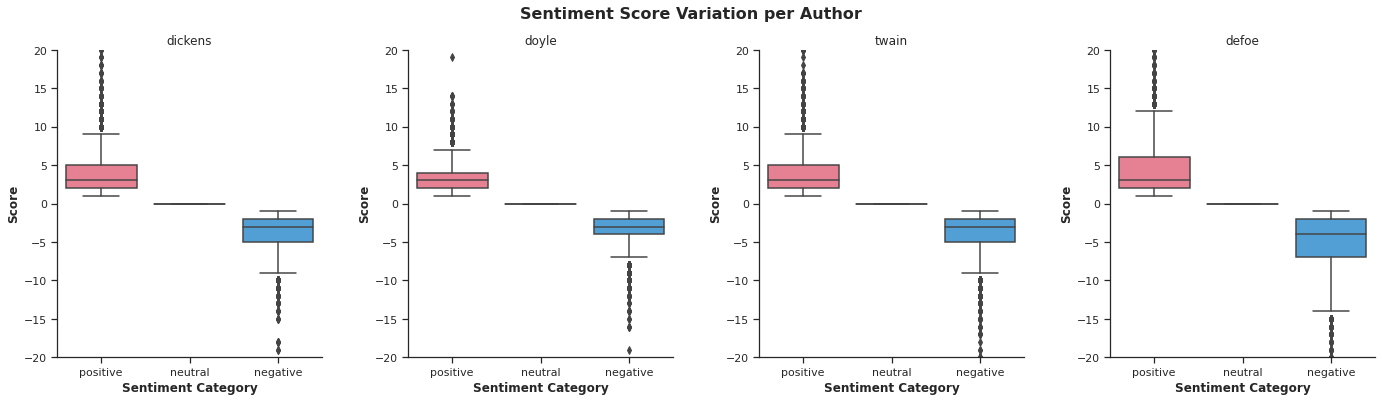

In [ ]:
authors = list(author_dict.values())

fig, axarr = plt.subplots(1,sentiment_df['author'].nunique(), figsize=(20, 6))

z = 0
for author_name in sentiment_df['author'].unique():
    df = sentiment_df[sentiment_df['author'] == author_name]
    ax = sns.boxplot(data = df, x = 'sentiment_category', y = 'score', ax=axarr[z],palette = 'husl', order=["positive", "neutral", "negative"])
    ax.set(ylim=(-20, 20))
    axarr[z].set_title(author_name)
    axarr[z].set_xlabel('Sentiment Category',fontsize = 12,weight = 'bold')
    axarr[z].set_ylabel('Score',fontsize = 12,weight = 'bold')
    z +=1

sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout(pad=3.0)
plt.suptitle('Sentiment Score Variation per Author',fontsize=16, weight = 'bold');

* Overall, all authors present a similar pattern for positive and negative samples (median and lower/upper quartiles).
      -->Defoe has highest variation in scores as compare to other three.
* Most samples are within the values of 5 and -5


## 1.3 Word Frequency By Author

Here we analyse the commonly used words according to each author. Common **Stop Words** are excluded, and stemming is performed. The result is shown in the plots below:

In [ ]:

freqs_author, words = build_freqs(df_train['text'], df_train['author'])

freq_words = []

for word in words:
    dickens = 0
    doyle = 0
    defoe = 0
    twain= 0 
    if (word, 'dickens') in freqs_author:
        dickens = freqs_author[(word, 'dickens')]
    if (word, 'doyle') in freqs_author:
        doyle = freqs_author[(word, 'doyle')]
    if (word, 'defoe') in freqs_author:
        defoe = freqs_author[(word, 'defoe')]   
    if (word, 'twain') in freqs_author:
        twain = freqs_author[(word, 'twain')]   
               
    freq_words.append([word, dickens,doyle,defoe,twain])   

freq_wordsDF = pd.DataFrame(freq_words, columns = ['word', 'dickens','doyle','defoe','twain'])    
freq_wordsDF['sum'] =  freq_wordsDF.loc[:, ['dickens','doyle','defoe','twain']].sum(axis=1)
freq_wordsDF.sort_values('sum', ascending=False,inplace=True)
freq_wordsDF.drop_duplicates(inplace=True)

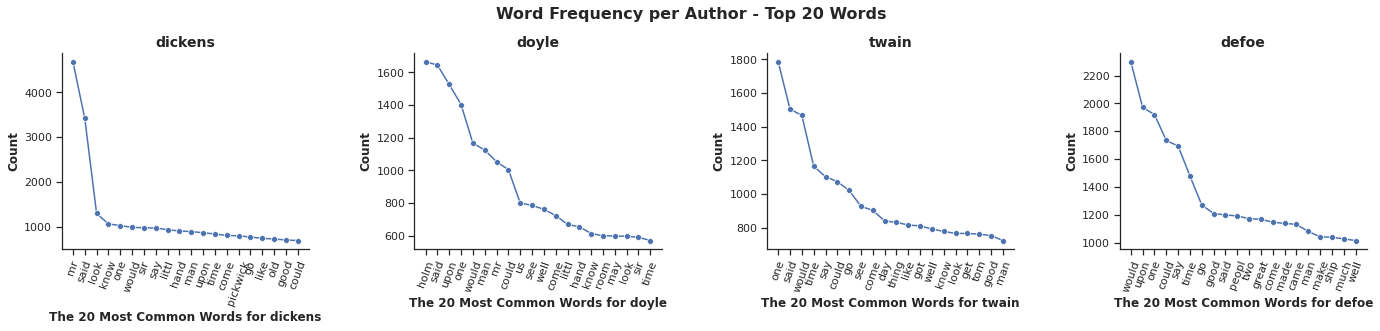

In [ ]:
z = 0; j = 0
fig, axarr = plt.subplots(1,sentiment_df['author'].nunique(), figsize=(20, 5))

authors_abbr = list(sentiment_df['author'].unique())

for i in authors_abbr:
    df = freq_wordsDF.loc[:,['word',i]]
    df.sort_values(i, ascending=False,inplace=True)
    ax = sns.lineplot(data=df[0:20],x="word", y=i, marker='o',ax=axarr[z])
    axarr[z].tick_params(axis='x', rotation=70)    
    axarr[z].set_xlabel('The 20 Most Common Words for ' + i,fontsize = 12,weight = 'bold')
    axarr[z].set_ylabel('Count',fontsize = 12,weight = 'bold')
    axarr[z].set_title(i, fontsize = 14,weight = 'bold');
    sns.despine(top=True, right=True, left=False, bottom=False)
    z+=1
    #print(FreqDF[0:15]['word'])
    
fig.tight_layout(pad=3.0)
plt.suptitle('Word Frequency per Author - Top 20 Words',fontsize=16, weight = 'bold');
plt.show()

* All four of authors do have different top20 words plots. However Author Dickens like to use word Mr. (4000 times) than any other author. which can be used as proxy that Dickens usually write in formal language ?

Below we have a plot that compares the usage of the same word across the three authors. A 3D plot and a 2d cross-sections are shown to better visualise:

## 1.4 Co-occurrence Word Pattern

Here we study the relantioship between words. The intent is to understand which words are most commonly used in the same sample. 

The **CountVecorizer** library is used to perform this analysis, and it is defined to extract the top 20 words by setting **max_features = 20**. Adding more features makes it harder to interpret the data. 

A heatmap is used to demonstrate the relationship between the words:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


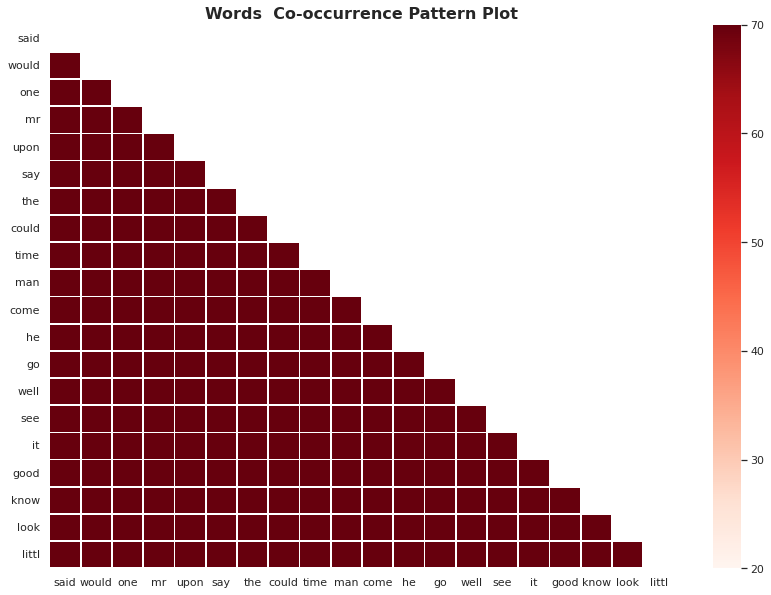

In [ ]:
Corpus = df_train['text'].sample(frac=0.6, random_state=1) #extract sample from Dataset, Adding the whole dataset does not change the pattern
Corpus = list(Corpus) #The CountVectorizer needs the inputs as list

count_model = CountVectorizer(preprocessor = preprocess_sentence, max_features = 20) #extracts the top most used words, uses my function to preprocess
CountVectData = count_model.fit_transform(Corpus) #fits and transforms to my corpus
CountVectDatac = (CountVectData.T * CountVectData) # this is co-occurrence matrix in sparse csr format
CountVectDatac.setdiag(0) # fill same word co-occurence as zero, they have much higher numbers than the remaining words

#Create DF
CountVectDF = pd.DataFrame(CountVectDatac.A, columns=count_model.get_feature_names(), index = count_model.get_feature_names()) #creates DF 
hour_count = CountVectDF.sum(axis=1) #Creates a sum column to be used to order entries

sorter = hour_count.sort_values(ascending = False).index #sorter of rows and columns
CountVectDF = CountVectDF[sorter] #sorts columns according to most occurred word
CountVectDF = CountVectDF.reindex(sorter) #sorts rows in the same order as columns

#Plot
mask = np.zeros_like(CountVectDF)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14,10))
    ax = sns.heatmap(CountVectDF, mask=mask, vmax = 70, vmin = 20, linewidths=.8,annot=False,cmap = 'Reds',annot_kws={"size": 10},cbar=True)
plt.title('Words  Co-occurrence Pattern Plot', fontsize = 16,weight = 'bold');    

* By ranking the words according to the number of co-occurrence, the plot created a nice vertical gradient
* There is a clear vertical pattern break from the word **even** and onwards
* The gradient shows that the words co-occur the most are used together most often, i.e. the top three words **could, would, upon** are commonly used with **one** (the most co-occurred word)
* For most words, the peak of occurrence occurs with one of the top four words (**one, could, would, upon**)
* Outlier from this trend are the words **seem** and **look**, which can also be commonly used with **eye** and **like**

Another interesting analysis would be to create the same plot by author or by sentiment analysis class (positive, negative, neutral).

## 1.5 Word Cloud

No text analysis is complete without a word cloud. Here, I created the mask using PowerPoint Icons and saved as PNG image. Just in case is not clear, the image is a pumpkin, a bat and a headstone with Rest in peace (RIP), or from the *Latin*, Requiescat In Pace.

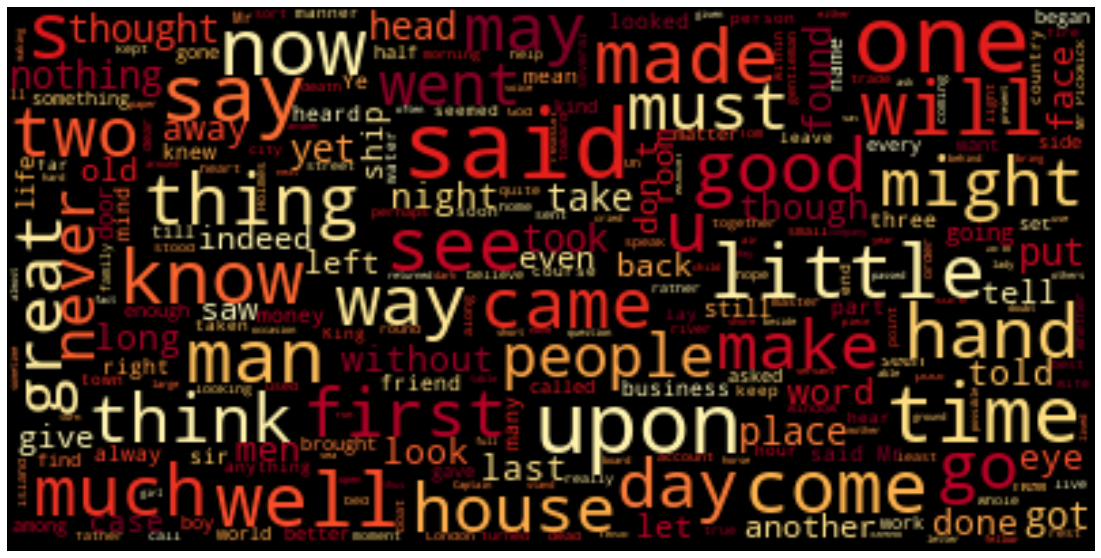

In [ ]:
#author_mask = np.array(Image.open(urlopen('https://github.com/negrinij/NLP-AuthorsChallenge/blob/main/images/Hallowen1.PNG?raw=true')))
   
wc = WordCloud(background_color="black",contour_width=0.1,colormap = 'YlOrRd',max_words=2000,max_font_size=36, random_state=42)
text = " ".join(review for review in df_train.text)
wc.generate(text)

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# 2. NLP Model

To build the NLP model, this [notebook](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) has really helped to better understand the NLP process. As mentioned on that Notebook, Kaggle is using a multi-class log-loss as evaluation metric. The LogLoss is a Logarithmic Loss metric, as such, the lower the value the better.

The implementation was taken from [here](https://github.com/dnouri/nolearn/blob/master/nolearn/lasagne/util.py):

In [ ]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

## 2.1 Data Preprocessing

For the Data Analysis section we played with preprocessing. Now we are going to prepare our dataset for our ML model:
* Encode the Labels
* Pre-Process text samples (stemming, stopwords, lowercase, remove punctuations)
* Oragnise the Training, Validation and Test Sets
* Use CountVectorizes to build the word vector

An additional step that has improved performance was to add the most common words to the **Stop_Words** list. The model improved by removing *one, could, and would* from the samples. In addition, not transforming the words to lowercase also increased model performance.

>Data Preprocessing and Creation of Training and Test Sets

In [ ]:
stop_words.update(('one','could','would'))

df_train = pd.read_csv('/content/drive/MyDrive/assignment1 autho classifcaition/train-authors - train-authors.csv')
df_test = pd.read_csv('/content/drive/MyDrive/assignment1 autho classifcaition/test-authors - test-authors.csv')

df_train['text_pre'] = df_train['text'].apply(lambda x : preprocess_sentence(x))
df_test['text_pre'] = df_test['text'].apply(lambda x : preprocess_sentence(x))

LabelEnc = preprocessing.LabelEncoder()
target_train = LabelEnc.fit_transform(df_train.author.values)

features_train = df_train.text_pre.values

features_test = df_test.text_pre.values

# Create First Train and Test sets
x_train, x_test, y_train, y_test = train_test_split(features_train, target_train, test_size=0.20,random_state=123)

print ("Training set size", x_train.shape[0])
print ("Test set size",x_test.shape[0])

Training set size 24000
Test set size 6000


>Using CountVectorize to transform the data and train our Naive-Bayes and Logistic Regression Models

In [ ]:
CVec = CountVectorizer(analyzer='word',ngram_range=(1, 3),dtype=np.float32)

# Fitting Count Vectorizer to training and test sets
x_train_CVec =  CVec.fit_transform(x_train) 
x_test_CVec = CVec.transform(x_test)

submission_test = CVec.transform(features_test)

>I have also tried using TF.IDF to transform the data and train the models. However, CountVectorizer has shown to be the best option for this application

In [ ]:
tfidf_vec = TfidfVectorizer(dtype=np.float32, sublinear_tf=True, use_idf=True, smooth_idf=True)

# Fitting TFIDF to trainingand test sets
x_train_tfidf = tfidf_vec.fit_transform(x_train)
x_test_tfidf = tfidf_vec.transform(x_test)

# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
#svd = decomposition.TruncatedSVD(n_components=200)
#xtrain_svd = svd.fit_transform(x_train_tfidf)
#xtest_svd = svd.transform(x_test_tfidf)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
#Scaler = preprocessing.StandardScaler()
#xtrain_svd_scl = Scaler.fit_transform(xtrain_svd)
#xtest_svd_scl = Scaler.transform(xtest_svd)

The models used for this study are the classic Naive-Bayes (NB) and Logistic Regression (LR), commonly used for NLP tasks. In addition, I am also using LGBM as it usually provides a good trade-off between accuracy and training time.

The model hyperparameters were optimised using the Optuna Library. The code for the optimisation is commented out as it requires a long time for the LGBM and LR.

In [ ]:
# The classification Models
LR = LogisticRegression(C=1, solver = 'lbfgs', max_iter = 1000)
NB = MultinomialNB(alpha = 1.3)
clf_LGBM = lgbm.LGBMClassifier(objective='multiclass',
                               metric = 'multi_logloss',
                               verbose=-1, 
                               learning_rate=0.08, 
                               max_depth=87, 
                               num_leaves=91, 
                               early_stopping_round = 100, 
                               n_estimators = 10000,
                               reg_alpha = 0.0003,
                               reg_lambda = 0.02897)

We validate the models using a K-Fold strategy. Five folds were selected as this ratio provides a good balance between training and validation sets. For the cross-validation, approximately 12.000 samples are used for training and 3.000 for validation for each fold. The mean LogLoss for the five folds and the Standard Deviation are recorded for model evaluation. Ideally, the CV result and the separate Test set scores should be similar as an indication that the model is not overfitting.

In [ ]:
kf = KFold(n_splits=5, shuffle = True, random_state = 123)

def CV(model,x_train,x_test):
    logloss = []
    for train_index, test_index in kf.split(x_train):
            X_train, X_val = x_train[train_index], x_train[test_index]
            Y_train, Y_val = y_train[train_index], y_train[test_index]        
            model.fit(X_train, Y_train)
            predictions = model.predict_proba(X_val)
            logloss.append(multiclass_logloss(Y_val, predictions))
    test_score = multiclass_logloss(y_test, model.predict_proba(x_test))
    mean_res = np.mean(logloss)
    std_dev = np.std(logloss)
    return mean_res,std_dev, test_score, model    

def CV_LGBM(model,x_train,x_test):
    logloss = []
    for train_index, test_index in kf.split(x_train):
            X_train, X_val = x_train[train_index], x_train[test_index]
            Y_train, Y_val = y_train[train_index], y_train[test_index]
            model.fit(X_train, Y_train, eval_metric='multi_logloss', eval_set=[(X_val, Y_val)],verbose=0)
            predictions = model.predict_proba(X_val)
            logloss.append(multiclass_logloss(Y_val, predictions))
    test_score = multiclass_logloss(y_test, model.predict_proba(x_test))
    mean_res = np.mean(logloss)
    std_dev = np.std(logloss)
    return mean_res,std_dev,test_score,model  

#LR_Model = CV(LR,x_train_CVec,x_test_CVec)
#NB_Model = CV(NB,x_train_CVec,x_test_CVec)
#LGBM_Model = CV_LGBM(clf_LGBM,x_train_CVec,x_test_CVec)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:12

An additional ensemble model is created to verify if such strategy could provide any significant improvement to our model. The sklearn library provides the VotingClassifier module to facilitate the ensemble model construction.

In [ ]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[('LR', LR), ('NB', NB)], voting='soft', weights=[1,1.5])
Ensemble_Model = CV(ensemble,x_train_CVec,x_test_CVec)

In [ ]:
def create_model(trial):
    #regularization = trial.suggest_loguniform('logistic-regularization', 0.0001, 1)
    #lr_solver = trial.suggest_categorical('solver', ["sag", "saga",'lbfgs'])
    #model = LogisticRegression( C=regularization, solver='lbfgs', max_iter = 100)#,intercept_scaling = lr_intercept_scaling)
    
    #NBAlpha = trial.suggest_loguniform('logistic-regularization', 0.0001, 1)
    #model = MultinomialNB(alpha = NBAlpha)
    
    #LGBM_alpha = trial.suggest_loguniform('LGBM_alpha', 0.0001, 1)
    #LGBM_lambda = trial.suggest_loguniform('LGBM_lambda', 0.0001, 1)
    LGBM_num_leaves = trial.suggest_int('LGBM_num_leaves', 5, 500)
    LGBM_max_depth = trial.suggest_int('LGBM_max_depth', 5, 500)
    LGBM_LR = trial.suggest_loguniform('LGBM_LR', 0.01, 0.1)
    #LGBM_estimators = trial.suggest_int('LGBM_estimators', 50, 10000)
    
    model = lgbm.LGBMClassifier(objective = 'multiclass',
                           metric = 'multi_logloss',
                           learning_rate = LGBM_LR,
                           early_stopping_round = 50,
                           n_estimators = 10000,
                           max_depth=LGBM_max_depth, num_leaves=LGBM_num_leaves,reg_alpha = 0.0003,reg_lambda = 0.02897,verbose = -1)  
    
    if trial.should_prune():
            raise optuna.TrialPruned()
    return model

def objective(trial):
    model = create_model(trial)
    accuracy,_,_,_ = CV_LGBM(clf_LGBM,x_train_CVec,x_test_CVec)
    # Save a trained model to a file.
    with open("{}.pickle".format(trial.number), "wb") as fout:
        pickle.dump(model, fout)
    return accuracy

#study = optuna.create_study(direction="minimize");
#study.optimize(objective, n_trials=10);
#print("Mean of Cross-Validation Sets: %.4f"% (study.best_value))
#print("The best parameters are: ", (study.best_params))

# 3. Result

Here we discuss the results from the modelling strategy we applied. The print statement below show us the LogLoss for each model for the Cross-Validation and Test sets.

In [ ]:
#print("Logistic Regression \n LogLoss: %.3f +/- %.4f \n Test Set LogLoss: %.3f" % (LR_Model[0],LR_Model[1],LR_Model[2]))
#print("Naive-Bayes \n LogLoss: %.3f +/- %.4f \n Test Set LogLoss: %.4f" % (NB_Model[0],NB_Model[1],NB_Model[2]))
#print("LGBM \n LogLoss: %.3f +/- %.4f \n Test Set LogLoss: %.3f" % (LGBM_Model[0],LGBM_Model[1],LGBM_Model[2]))
print("Ensemble NB and LR \n LogLoss: %.3f +/- %.4f \n Test Set LogLoss: %.3f" % (Ensemble_Model[0],Ensemble_Model[1],Ensemble_Model[2]))

Logistic Regression 
 LogLoss: 0.345 +/- 0.0155 
 Test Set LogLoss: 0.337
Naive-Bayes 
 LogLoss: 0.374 +/- 0.0238 
 Test Set LogLoss: 0.4866
LGBM 
 LogLoss: 0.349 +/- 0.0117 
 Test Set LogLoss: 0.335
Ensemble NB and LR 
 LogLoss: 0.263 +/- 0.0153 
 Test Set LogLoss: 0.283


* Logistic Regression and Naive-Bayes outperformed LGBM by almost a decimal point
* The Ensemble Model has improved the result considerably, showing a smaller LogLoss and also reducing the Standard Deviation between the validation sets
* As LGBM has shown the worse result, it will not be considered for further Error Analysis

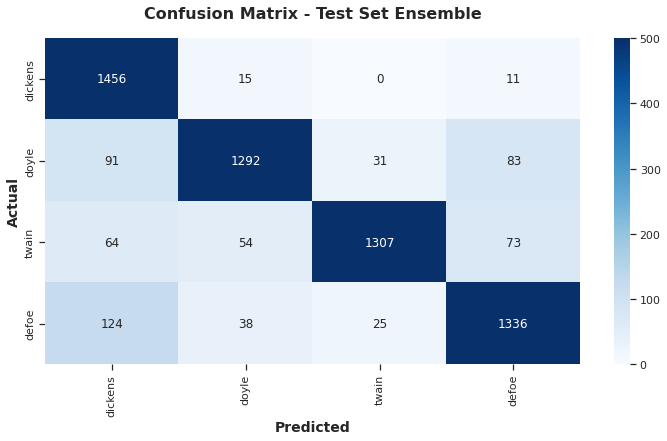

In [ ]:
#LR_preds = LR_Model[3].predict(x_test_CVec)
#NB_preds = NB_Model[3].predict(x_test_CVec)
Ensemble_preds = Ensemble_Model[3].predict(x_test_CVec)

categories = [df_train['author'].unique()]

def CMatrix(predictions, title):
    CMatrix = pd.DataFrame(confusion_matrix(y_test, predictions), columns=categories, index =categories )

    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 500,cmap = 'Blues')
    ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
    ax.set_xticklabels(ax.get_xticklabels(),rotation =90);
    ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')    
    ax.set_title('Confusion Matrix - Test Set ' + title,fontsize = 16,weight = 'bold',pad=20);

#CMatrix(LR_preds,'Logistic Regression')
#CMatrix(NB_preds,'Naive-Bayes')
CMatrix(Ensemble_preds,'Ensemble')

In [ ]:
sum(y_test==Ensemble_preds)/y_test.shape[0]

0.8985

In [ ]:
list(LabelEnc.inverse_transform([2, 2, 1]))

['doyle', 'doyle', 'dickens']

* EAP is most often misclassified as MWS than HPL, this trend is seen on all three ML models
* In a similar manner, HPL is most often misclassified as EAP
* MWS samples also present higher number of samples misclassified as EAP
* All three ML models present the same pattern of misclassifications, i.e. HPL and MWS samples being misclassified as EAP
* The Ensemble Model presents a higher number of TP for MWS and EAP and reduced the TP for HPL

The code below is to prepare the CSV file for submission. Since the competition is no longer open, only manual submission is allowed. 

In [ ]:
ensemble_preds = Ensemble_Model[3].predict(submission_test)
ids = df_test.copy()
predict = pd.DataFrame(ensemble_preds, columns=['predicted_author_name'] )
predict['predicted_author_name'] = LabelEnc.inverse_transform(predict['predicted_author_name'].values)
submission = pd.concat([ids, predict] ,axis = 1)
submission.to_csv('results.csv',index=False)
submission.head()

,text,author,text_pre,predicted_author_name
0,"Carton,” said the man of business. “Good night, Mr. \nDarnay. Shall we ever see such a night again, together!”\n\nPerhaps. Perhaps, see the great crowd of people with its rush and roar,\nbearing down upon them, too",dickens,carton said man busi good night mr darnay shall ever see night togeth perhap perhap see great crowd peopl rush roar bear upon,dickens
1,"_Is taken, and\nhow_, 154. _Tried, condemned, and executed at_ Jamaica, ib. _The Names of\nhis Crew condemn'd with him_, 154. _An extraordinary Case of nine taken\nwith him_, ib. _Some Account of the Proceedings against them_, 154, 155",defoe,is taken 154 tri condemn execut jamaica ib the name crew condemn 154 an extraordinari case nine taken ib some account proceed 154 155,defoe
2,"Through a cousin who\n works with Gelder, he found out the retail firms who had bought\n the busts. He managed to find employment with Morse Hudson, and\n in that way tracked down three of them",doyle,through cousin work gelder found retail firm bought bust he manag find employ mors hudson way track three,doyle
3,"\n\nIndeed, nothing was more strange than to see with what courage the\npeople went to the public service of God, even at that time when they\nwere afraid to stir out of their own houses upon any other occasion\n(this I mean before the time of desperation which I have mentioned\nalready)",defoe,inde noth strang see courag peopl went public servic god even time afraid stir hous upon occas i mean time desper i mention alreadi,defoe
4,"\n\nOn the rocks above the present city of Alton they found some rude and\nfantastic Indian paintings, which they describe. A short distance below\n'a torrent of yellow mud rushed furiously athwart the calm blue current\nof the Mississippi, boiling and surging and sweeping in its course logs,\nbranches, and uprooted trees",twain,on rock present citi alton found rude fantast indian paint describ a short distanc torrent yellow mud rush furious athwart calm blue current mississippi boil surg sweep cours log branch uproot tree,twain


In [ ]:
from sklearn.metrics import f1_score

f1_score(submission['author'], submission['predicted_author_name'],average='weighted')

0.8984762931245678